Valid:
* TOB3_long2
* TOB3_long3
* TOB3_long4

Processing files: 100%|██████████| 274k/274k [00:00<00:00, 10.6MB/s]


"TS","RN","","",""


,TIMESTAMP,text_val,text_val_2,text_val_3
RECORD,,,,


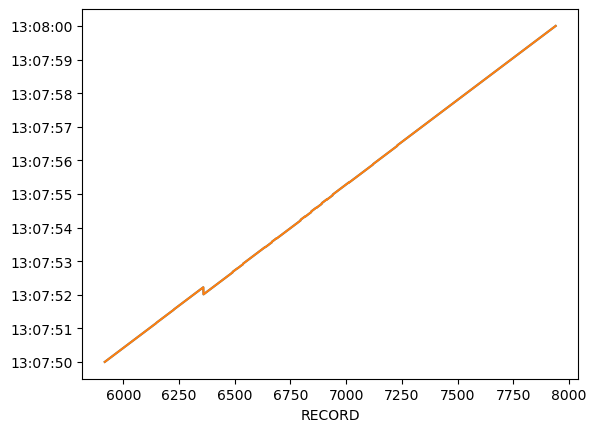

In [4]:
import pandas as pd
from camp2ascii import camp2ascii

ref_file = "/Users/alex/Library/CloudStorage/OneDrive-UniversityofWyoming/Work/UWyo/Research/camp2ascii/tests/cc/TOA5_TOB3_partial3_2026_02_20_1307.dat"
my_file = "/Users/alex/Library/CloudStorage/OneDrive-UniversityofWyoming/Work/UWyo/Research/camp2ascii/tests/raw/TOB3_partial3.dat"

my_tob3 = pd.read_csv(
    camp2ascii(my_file, "/Users/alex/Library/CloudStorage/OneDrive-UniversityofWyoming/Work/UWyo/Research/camp2ascii/tests/c2a", n_invalid=None, pbar=True, verbose=3)[0],
    skiprows=[0, 2, 3], na_values=["NAN", "NaN", "nan", "-9999"]
).set_index("RECORD")
# my_tob3 = pd.read_csv(
#     "/Users/alex/Library/CloudStorage/OneDrive-UniversityofWyoming/Work/UWyo/Research/camp2ascii/tests/c2a/TOA5_TOB3_partial3.dat",
#     skiprows=[0, 2], na_values=["NAN", "NaN", "nan", "-9999"]
# )

ref_tob3 = pd.read_csv(
    ref_file,
    skiprows=[0, 2, 3], na_values=["NAN", "NaN", "nan", "-9999"]
).set_index("RECORD")


my_tob3['TIMESTAMP'] = pd.to_datetime(my_tob3['TIMESTAMP'], format="ISO8601")
ref_tob3['TIMESTAMP'] = pd.to_datetime(ref_tob3['TIMESTAMP'], format="ISO8601")

# ref_tob3 = ref_tob3.sort_values("TIMESTAMP")
# my_tob3 = my_tob3.sort_values("TIMESTAMP")

ref_tob3.sort_index(inplace=True)
my_tob3.sort_index(inplace=True)

start, end = 6310, 6410
start, end = my_tob3.index[0], my_tob3.index[-1]
# start, end = 7100, 7200
my_tob3["TIMESTAMP"].loc[start:end].plot()
ax = ref_tob3["TIMESTAMP"].loc[start:end].plot(color="C1")

# ax.set_ylim(pd.to_datetime("2026-02-20 13:07:52"), pd.to_datetime("2026-02-20 13:07:52.25"))
# ax.set_yticks(pd.to_datetime(["2026-02-20 13:07:52.00", "2026-02-20 13:07:52.25"]))
# my_tob3.shape, ref_tob3.shape

import numpy as np
ref_tob3.loc[np.setdiff1d(np.union1d(my_tob3.index, ref_tob3.index), np.intersect1d(my_tob3.index, ref_tob3.index))]

# # my_tob3

In [118]:
minor_frame_headers_raw = [b'(\xbf\xf9C\x02\x08\x00\x00\xd3\x18\x00\x00', b'(\xbf\xf9C\x96\x00\x00\x00\xd8\x18\x00\x00']


print(pd.to_datetime([((631152000+int.from_bytes(h[:4], "little"))*1000000000 + int(int.from_bytes(h[4:8], "little")*100e-6*1e6)*1000) for h in minor_frame_headers_raw], unit="ns"))
print([int.from_bytes(h[8:], "little") for h in minor_frame_headers_raw])

DatetimeIndex(['2026-02-20 13:07:52.205000', '2026-02-20 13:07:52.015000'], dtype='datetime64[ns]', freq=None)
[6355, 6360]


In [1]:
from unittest import TestCase
from math import ceil
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import camp2ascii.formats as fmt
from camp2ascii import camp2ascii

fmt.REPAIR_MISALIGNED_MINOR_FRAMES = False


parent = Path("/home/alextsfox/git-repos/camp2ascii/tests")

in_dir = parent / "raw"

out_dir = parent / "c2a"
out_dir.mkdir(parents=True, exist_ok=True)

# fig, axs = plt.subplots(ceil(20/2), 2, figsize=(12, 15), sharex=True)
try:
    out_files = camp2ascii(in_dir, out_dir, pbar=True, verbose=3)
    for f in out_files:
        file_type = re.search(r"TOB\d", f.name).group(0)

        my_tob3 = pd.read_csv(f, skiprows=[0, 2, 3], na_values=["NAN", '"NAN"'])
        my_tob3["TIMESTAMP"] = pd.to_datetime(my_tob3["TIMESTAMP"], format="ISO8601")

        ref_file = list((out_dir.parent / "cc").glob(f"*{f.stem}*"))[0]
        ref_tob3 = pd.read_csv(ref_file, skiprows=[0, 2, 3], na_values=["NAN", '"NAN"'])
        ref_tob3["TIMESTAMP"] = pd.to_datetime(ref_tob3["TIMESTAMP"], format="ISO8601")

        if "temp_TMx(1)" in ref_tob3.columns:
            ref_tob3["temp_TMx(1)"] = pd.to_datetime(ref_tob3["temp_TMx(1)"], format="ISO8601")
            my_tob3["temp_TMx(1)"] = pd.to_datetime(my_tob3["temp_TMx(1)"], format="ISO8601")
        
        for col in ref_tob3.columns:
            if col in {"TIMESTAMP", "temp_TMx(1)"}:
                ref_tob3[col] = ref_tob3[col].astype(np.int64)
                my_tob3[col] = my_tob3[col].astype(np.int64)
            ref_tob3[col] = ref_tob3[col].astype(np.float64)
            my_tob3[col] = my_tob3[col].astype(np.float64)

        ref_tob3 = ref_tob3.set_index("RECORD")
        my_tob3 = my_tob3.set_index("RECORD")


        common_idx = ref_tob3.index.union(my_tob3.index)
        if file_type == "TOB3" and ref_tob3["TIMESTAMP"].diff().diff().abs().max() > 1e5:  # 100us
            common_idx = ref_tob3.index.intersection(my_tob3.index)
        ref_tob3 = ref_tob3.loc[common_idx].sort_index()
        my_tob3 = my_tob3.loc[common_idx].sort_index()

        print(np.allclose(ref_tob3, my_tob3, equal_nan=True))
finally:
    for f in out_files:
        f.unlink(missing_ok=True)

Processing files:  31%|███▏      | 221k/708k [00:00<00:00, 1.08MB/s] 

huh?
huh?
huh?
huh?
huh?
huh?


Processing files:  61%|██████    | 430k/708k [00:00<00:00, 1.04MB/s]

huh?
huh?
huh?
huh?
huh?
huh?


Processing files:  87%|████████▋ | 615k/708k [00:00<00:00, 954kB/s] 

huh?
huh?
huh?
huh?
huh?
huh?


Processing files: 865kB [00:00, 999kB/s]                           

huh?
huh?
huh?
huh?
huh?
huh?


Processing files: 100%|██████████| 708k/708k [00:01<00:00, 650kB/s]

huh?
huh?
huh?
huh?


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
